# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.112003,True,6.185237
1,0.184925,False,-1.578231
2,0.952604,False,1.449819
3,0.946551,True,8.404735
4,0.356712,True,5.772946
...,...,...,...
995,0.915931,True,5.927939
996,-1.097095,False,-1.231371
997,0.607962,True,2.862744
998,0.680794,True,5.167180


<AxesSubplot:xlabel='v0'>

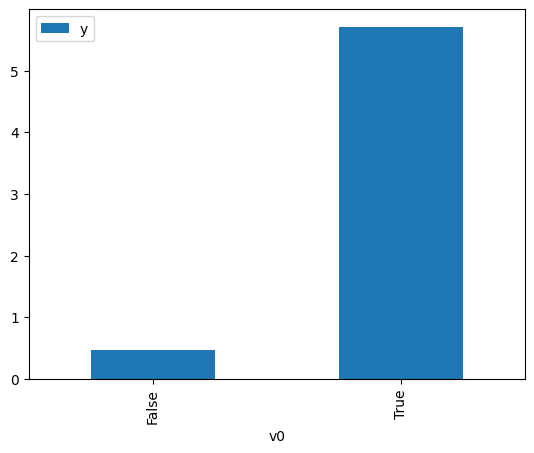

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

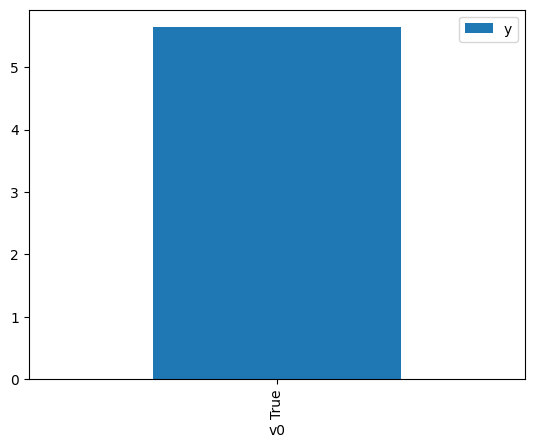

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.043345,False,1.343102,0.067201,14.880738
1,1.471761,False,2.576858,0.022312,44.818637
2,1.471761,False,2.576858,0.022312,44.818637
3,-1.023744,False,-1.114682,0.948635,1.054147
4,1.312429,False,0.256365,0.033813,29.574846
...,...,...,...,...,...
995,1.043345,False,1.343102,0.067201,14.880738
996,0.841934,False,0.626565,0.110067,9.085411
997,1.134521,False,1.508177,0.053396,18.728101
998,-1.000468,False,-2.114149,0.945505,1.057636


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.213307,True,4.183742,0.031532,31.713741
1,3.812234,True,5.742081,0.999957,1.000043
2,0.736457,True,4.128071,0.859004,1.164139
3,1.613649,True,6.301445,0.984644,1.015595
4,0.199173,True,7.112640,0.590337,1.693947
...,...,...,...,...,...
995,0.486798,True,6.304761,0.757153,1.320736
996,-0.232262,True,5.387088,0.311675,3.208466
997,0.406203,True,6.780357,0.715221,1.398170
998,1.148272,True,6.450302,0.948439,1.054364


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.317e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        16:33:08   Log-Likelihood:                         -1405.3
No. Observations:                1000   AIC:                                      2815.
Df Residuals:                     998   BIC:                                      2824.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7189      0.040     17.957      0.000       0.640       0.798
x2             5.0809      0.059     85.788      0.000       4.965       5.197
==============================================================================
Omnibus:                        0.414   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.813   Jarque-Bera (JB):                0.468
Skew:                           0.046   Prob(JB):                        0.791
Kurtosis:                       2.948   Cond. No.                         3.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""